In [ ]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
  # Implement Categorical OneHot encoding for ISA and mem-type
  if encode_decode == 'encode':
    encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
    encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem_type'])
    encoder_isa.fit(data_frame, verbose=1)
    df_new1 = encoder_isa.transform(data_frame)
    encoder_mem_type.fit(df_new1, verbose=1)
    df_new = encoder_mem_type.transform(df_new1)
    encoded_data_frame = df_new
  else:
    df_new1 = encoder_isa.transform(data_frame)
    df_new = encoder_mem_type.transform(df_new1)
    encoded_data_frame = df_new
        
  return encoded_data_frame, encoder_isa, encoder_mem_type

In [ ]:
def split_dataset(X, y):
  # split into train and test
  #X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, X.index, test_size=0.2, random_state=42)
  # use default random state of np.random, so not providing any value here
  X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, X.index, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test, indices_train, indices_test

In [ ]:
def scale_train_dataset(X_train, y_train, input_scaler=None, output_scaler=None):
  # scale X_train input (fit and transform)
  if input_scaler is not None:
    # fit scaler on training dataset
    input_scaler.fit(X_train)
    # transform training dataset
    X_train = input_scaler.transform(X_train)        
        
  # scale y_train input (fit and transform)
  if output_scaler is not None:
    # fit scaler on training dataset
    output_scaler.fit(y_train)
    # transform training dataset
    y_train = output_scaler.transform(y_train)        
        
  return X_train, y_train, input_scaler, output_scaler

In [ ]:
def scale_test_dataset(X_test, y_test, input_scaler, output_scaler):
  # scale X_test input (only transform)
  if input_scaler is not None:
    # transform test dataset
    X_test = input_scaler.transform(X_test)
        
  # scale y_train input (only transform)
  if output_scaler is not None:
    # transform test dataset
    y_test = output_scaler.transform(y_test)
        
  return X_test, y_test

In [ ]:
def perform_dataset_ops(benchmark, algo, algo_fname):
  print(benchmark, algo, algo_fname)
  df_orig=pd.read_csv(drive_location+algo_fname+".csv")
  #df_orig.dropna(inplace=True)
    
  # Encode text features
  df_encoded, encoder_isa, encoder_mem_type = encode_text_features('encode', df_orig)
  print("df_orig====================>",df_orig)
  print("df_encoded====================>",df_encoded)
  # store learned models in dictory
  dataset = {}
  dataset['encoder_isa'] = encoder_isa
  dataset['encoder_mem_type'] = encoder_mem_type
    
  dataset['df_orig'] = df_orig
  dataset['df_encoded'] = df_encoded

#  for ps_indx, ps in enumerate(df_orig.PS.unique()):
#    print(ps_indx, ps)
#    dataset[ps] = {}
    
#    criteria_df = (df_encoded['PS'] == ps)
    #print(criteria_df)
#    df_selected = df_encoded[criteria_df]
  df_selected = df_encoded    
  if (benchmark == "SPEC2006" or benchmark == "SPEC2017"):
    X_all=df_selected.drop(columns=['arch','ld_shared_by_cores','l2_shared_by_cores','no_of_threads','system_name','bus_speed_qpi','bus_speed_dmi','l1_ins_assoc','l1_data_assoc','l2_assoc','l3_assoc','raw_bus_speed','converted_bus_speed','ddr_type','runtime'])
  elif (benchmark == "NPB"):
    X_all=df_selected.drop(columns=['sys','sysname','arch','l1d_assoc','l1d_cache_lines','l1d_shared_by_threads','l2_assoc','l2_cache_lines','l2_shared_by_threads','l3_assoc','l3_cache_lines','l3_shared_by_threads','PS','runtime','executable','system'])
  else:
    X_all=df_selected.drop(columns=['sys','arch','l1d_assoc','l1d_cache_lines','l1d_shared_by_threads','l2_assoc','l2_cache_lines','l2_shared_by_threads','l3_assoc','l3_cache_lines','l3_shared_by_threads','runtime'])
  #print(X_all)
  X_all.dropna(inplace=True)
  dataset['X_all'] = X_all
  
  # Output
  y=df_selected[['runtime']]
  print("y shape ",y.shape, "y types", y.dtypes)
  #print("y shape ",y.shape, "y types", y.dtypes)
  dataset['y'] = y

  # split into train and test
  X_train, X_test, y_train, y_test, indices_train, indices_test = split_dataset(X_all, y)
  dataset['X_train'] = X_train
  dataset['X_test'] = X_test
  dataset['y_train'] = y_train
  dataset['y_test'] = y_test
  dataset['indices_train'] = indices_train
  dataset['indices_test'] = indices_test

  # unscaled inputs
  # scale train data (fit and transform)
  X_train_unscaled, y_train_unscaled, input_scaler_unscaled, output_scaler_unscaled = scale_train_dataset(X_train, y_train, None, StandardScaler())
  # scale test data (only transform)
  X_test_unscaled, y_test_unscaled = scale_test_dataset(X_test, y_test, input_scaler_unscaled, output_scaler_unscaled)
  dataset['X_train_unscaled'] = X_train_unscaled
  dataset['X_test_unscaled'] = X_test_unscaled
  dataset['y_train_unscaled'] = y_train_unscaled
  dataset['y_test_unscaled'] = y_test_unscaled
  dataset['input_scaler_unscaled'] = input_scaler_unscaled
  dataset['output_scaler_unscaled'] = output_scaler_unscaled
      
  #standardized inputs
  # scale train data (fit and transform)
  X_train_standardized, y_train_standardized, input_scaler_standardized, output_scaler_standardized = scale_train_dataset(X_train, y_train, StandardScaler(), StandardScaler())
  # scale test data (only transform)
  X_test_standardized, y_test_standardized = scale_test_dataset(X_test, y_test, input_scaler_standardized, output_scaler_standardized)
  dataset['X_train_standardized'] = X_train_standardized
  dataset['X_test_standardized'] = X_test_standardized
  dataset['y_train_standardized'] = y_train_standardized
  dataset['y_test_standardized'] = y_test_standardized
  dataset['input_scaler_standardized'] = input_scaler_standardized
  dataset['output_scaler_standardized'] = output_scaler_standardized
      
  save_learned_models(dataset, algo, "dataset")

In [ ]:
def save_learned_models(dct, algo, fname):
  pickleFile = drive_location+algo+"_"+fname+".pickle"
  with open(pickleFile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(dct, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_learned_models(algo, fname):
  pickleFile = drive_location+algo+"_"+fname+".pickle"
  f = open(pickleFile, 'rb')
  # disable garbage collector
  gc.disable()
  # The protocol version used is detected automatically, so we do not
  # have to specify it.
  data = pickle.load(f)
  # enable garbage collector again
  gc.enable()
  f.close()
  return data

In [ ]:
def build_nn_model(algo):
  dataset = load_learned_models(algo, "dataset")
  nnmodel = {}
  input_dim = dataset['X_train_standardized'].shape[1]
  output_dim = dataset['y_train_standardized'].shape[1]
  print('input_dim:', input_dim, 'output_dim:', output_dim)
  model_iter = 0
  rmse = 9999999999999999999999999
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(input_dim,)))
  while (True):
    if (model_iter > 0):
      # add layer with neurons = rmse*100
      model.add(tf.keras.layers.Dense(int(rmse*100), activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))
    # compile model
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
    # fit model
    model.fit(dataset['X_train_standardized'], dataset['y_train_standardized'], epochs=100, verbose=0)
    # evaluate the model
    y_train_pred = model.predict(dataset['X_train_standardized'])
    y_test_pred = model.predict(dataset['X_test_standardized'])
    prev_rmse = rmse
    rmse = mean_squared_error(dataset['y_train_standardized'],y_train_pred,squared=False)
    print(rmse, prev_rmse)
    if (rmse > prev_rmse):
      break
    #nnmodel['model'] = model
    model.save(drive_location+algo+"_nnmodel.h5")
    nnmodel[model_iter] = {}
    nnmodel[model_iter]['y_train'] = dataset['y_train_standardized']
    nnmodel[model_iter]['y_train_pred'] = y_train_pred
    nnmodel[model_iter]['y_test'] = dataset['y_test_standardized']
    nnmodel[model_iter]['y_test_pred'] = y_test_pred
    nnmodel[model_iter]['train_rmse'] = mean_squared_error(dataset['y_train_standardized'],y_train_pred,squared=False)
    nnmodel[model_iter]['train_medae'] = median_absolute_error(dataset['y_train_standardized'],y_train_pred)
    nnmodel[model_iter]['train_explained_var'] = explained_variance_score(dataset['y_train_standardized'],y_train_pred)
    nnmodel[model_iter]['test_rmse'] = mean_squared_error(dataset['y_test_standardized'],y_test_pred,squared=False)
    nnmodel[model_iter]['test_medae'] = median_absolute_error(dataset['y_test_standardized'],y_test_pred)
    nnmodel[model_iter]['test_explained_var'] = explained_variance_score(dataset['y_test_standardized'],y_test_pred)
    nnmodel[model_iter]['y_train_pred_error'] = np.abs((dataset['output_scaler_standardized'].inverse_transform(dataset['y_train_standardized']) - dataset['output_scaler_standardized'].inverse_transform(y_train_pred))/dataset['output_scaler_standardized'].inverse_transform(dataset['y_train_standardized'])*100)
    nnmodel[model_iter]['y_test_pred_error'] = np.abs((dataset['output_scaler_standardized'].inverse_transform(dataset['y_test_standardized']) - dataset['output_scaler_standardized'].inverse_transform(y_test_pred))/dataset['output_scaler_standardized'].inverse_transform(dataset['y_test_standardized'])*100)
    nnmodel[model_iter]['train_medape'] = np.median(nnmodel[model_iter]['y_train_pred_error'])
    nnmodel[model_iter]['test_medape'] = np.median(nnmodel[model_iter]['y_test_pred_error'])
    
    print('Neural Network Iteration {0}'.format(model_iter))
    print('Training Set: RMSE {0}, MedAE {1}, Explained Variance {2}, MedAPE {3}'.format(nnmodel[model_iter]['train_rmse'], nnmodel[model_iter]['train_medae'], nnmodel[model_iter]['train_explained_var'], nnmodel[model_iter]['train_medape']))
    print('Testing Set: RMSE {0}, MedAE {1}, Explained Variance {2}, MedAPE {3}'.format(nnmodel[model_iter]['test_rmse'], nnmodel[model_iter]['test_medae'], nnmodel[model_iter]['test_explained_var'], nnmodel[model_iter]['test_medape']))
    print(model.summary())
    model_iter = model_iter + 1
    # remove the output layer from previously built model
    model.pop()


  save_learned_models(nnmodel, algo, "nnmodel")
  print('Final Model--->')
  model1 = tf.keras.models.load_model(drive_location+algo+"_nnmodel.h5")
  model1.summary()


In [ ]:
def build_autokeras(algo):
  dataset = load_learned_models(algo, "dataset")
  reg = ak.StructuredDataRegressor(max_trials=3, overwrite=True)
  # Feed the tensorflow Dataset to the regressor.
  reg.fit(dataset['X_train_standardized'], dataset['y_train_standardized'], epochs=100)
  # Predict with the best model.
  y_train_pred = reg.predict(dataset['X_train_standardized'])
  y_test_pred = reg.predict(dataset['X_test_standardized'])

  autokerasmodel = {}
  autokerasmodel['y_train'] = dataset['y_train_standardized']
  autokerasmodel['y_train_pred'] = y_train_pred
  autokerasmodel['y_test'] = dataset['y_test_standardized']
  autokerasmodel['y_test_pred'] = y_test_pred
  autokerasmodel['train_rmse'] = mean_squared_error(dataset['y_train_standardized'],y_train_pred,squared=False)
  autokerasmodel['train_medae'] = median_absolute_error(dataset['y_train_standardized'],y_train_pred)
  autokerasmodel['train_explained_var'] = explained_variance_score(dataset['y_train_standardized'],y_train_pred)
  autokerasmodel['test_rmse'] = mean_squared_error(dataset['y_test_standardized'],y_test_pred,squared=False)
  autokerasmodel['test_medae'] = median_absolute_error(dataset['y_test_standardized'],y_test_pred)
  autokerasmodel['test_explained_var'] = explained_variance_score(dataset['y_test_standardized'],y_test_pred)
  autokerasmodel['y_train_pred_error'] = np.abs((dataset['output_scaler_standardized'].inverse_transform(dataset['y_train_standardized']) - dataset['output_scaler_standardized'].inverse_transform(y_train_pred))/dataset['output_scaler_standardized'].inverse_transform(dataset['y_train_standardized'])*100)
  autokerasmodel['y_test_pred_error'] = np.abs((dataset['output_scaler_standardized'].inverse_transform(dataset['y_test_standardized']) - dataset['output_scaler_standardized'].inverse_transform(y_test_pred))/dataset['output_scaler_standardized'].inverse_transform(dataset['y_test_standardized'])*100)
  autokerasmodel['train_medape'] = np.median(autokerasmodel['y_train_pred_error'])
  autokerasmodel['test_medape'] = np.median(autokerasmodel['y_test_pred_error'])
    
  print('Auto Keras-->')
  print('Training Set: RMSE {0}, MedAE {1}, Explained Variance {2}, MedAPE {3}'.format(autokerasmodel['train_rmse'], autokerasmodel['train_medae'], autokerasmodel['train_explained_var'], autokerasmodel['train_medape']))
  print('Testing Set: RMSE {0}, MedAE {1}, Explained Variance {2}, MedAPE {3}'.format(autokerasmodel['test_rmse'], autokerasmodel['test_medae'], autokerasmodel['test_explained_var'], autokerasmodel['test_medape']))

  # Export as a Keras Model.
  model = reg.export_model()
  try:
    model.save(drive_location+algo+"_model_autokeras", save_format="tf")
    loaded_model = load_model(drive_location+algo+"_model_autokeras", custom_objects=ak.CUSTOM_OBJECTS)
    #loaded_model = load_model(drive_location+algo+"_model_autokeras")
    print(loaded_model.predict(tf.expand_dims(dataset['X_test_standardized'], -1)))
  except Exception:
    model.save(drive_location+algo+"_autokeras.h5")

  save_learned_models(autokerasmodel, algo, "autokeras")

## Plotting

In [ ]:
def set_pub():
    mpl.rcdefaults()
    mpl.rcParams['font.size'] = 14
    #mpl.rcParams['font.weight'] = 'bold'
    mpl.rcParams['xtick.labelsize'] = 'xx-large'
    mpl.rcParams['ytick.labelsize'] = 'xx-large'
    mpl.rcParams['figure.titlesize'] = 'xx-large'
    mpl.rcParams['legend.fontsize'] = 'xx-large'
    mpl.rcParams['axes.titlesize'] = 'xx-large'
    mpl.rcParams['axes.titleweight'] = 'bold'
    mpl.rcParams['axes.labelsize'] = 'xx-large'
    mpl.rcParams['axes.labelweight'] = 'bold'
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 12
    print(mpl.rcParams['figure.titlesize'], mpl.rcParams['legend.fontsize'])
    plt.rc('figure', dpi=500)

In [ ]:
def capture_metric_in_csv(benchmark_title, algo_list):
  # First capture data in csv file for all algo
  metric_list = []
  for algo in algo_list:
    nnmodel = load_learned_models(algo, "nnmodel")
    final_nnmodel_key = list(nnmodel.keys())[-1]
    autokerasmodel = load_learned_models(algo, "autokeras")
    metric_dict = {}
    metric_dict['algo'] = algo
    # RMSE
    metric_dict['nnmodel_train_rmse'] = nnmodel[final_nnmodel_key]['train_rmse']
    metric_dict['autokerasmodel_train_rmse'] = autokerasmodel['train_rmse']
    metric_dict['nnmodel_test_rmse'] = nnmodel[final_nnmodel_key]['test_rmse']
    metric_dict['autokerasmodel_test_rmse'] = autokerasmodel['test_rmse']
    # MedAE
    metric_dict['nnmodel_train_medae'] = nnmodel[final_nnmodel_key]['train_medae']
    metric_dict['autokerasmodel_train_medae'] = autokerasmodel['train_medae']
    metric_dict['nnmodel_test_medae'] = nnmodel[final_nnmodel_key]['test_medae']
    metric_dict['autokerasmodel_test_medae'] = autokerasmodel['test_medae']
    # MedAPE
    metric_dict['nnmodel_train_medape'] = nnmodel[final_nnmodel_key]['train_medape']
    metric_dict['autokerasmodel_train_medape'] = autokerasmodel['train_medape']
    metric_dict['nnmodel_test_medape'] = nnmodel[final_nnmodel_key]['test_medape']
    metric_dict['autokerasmodel_test_medape'] = autokerasmodel['test_medape']

    print(metric_dict)
    metric_list.append(metric_dict)
  metric_df = pd.DataFrame.from_dict(metric_list)
  metric_df.to_csv(drive_location+benchmark_title+"_metric.csv", line_terminator='\n', index=False)

In [ ]:
def plot_nnmodel_vs_autokeras(benchmark_title, algo_list):
  capture_metric_in_csv(benchmark_title, algo_list)

  metric_df = pd.read_csv(drive_location+benchmark_title+"_metric.csv")
  y_pos = np.arange(metric_df.shape[0])
  print(y_pos)


  # Plot Train and Test MedAE for nnmodel (our model) and autokeras model 
  colors = ['r','k','b','y']
  fig, axes = plt.subplots(figsize=(len(y_pos)*1.5, 4))
  rect1 = []
  rect2 = []
  rect3 = []
  rect4 = []
  width = 0.2
  rect1 = plt.bar(y_pos, metric_df['nnmodel_train_medae'], width, color=colors[0])
  rect2 = plt.bar(y_pos+width, metric_df['autokerasmodel_train_medae'], width, color=colors[1])
  rect3 = plt.bar(y_pos+2*width, metric_df['nnmodel_test_medae'], width, color=colors[2])
  rect4 = plt.bar(y_pos+3*width, metric_df['autokerasmodel_test_medae'], width, color=colors[3])
  
  plt.xticks(y_pos+1.5*width, metric_df['algo'], rotation=20, ha='right')
  plt.ylabel('MedAE')
  plt.xlabel(benchmark_title)
  #lgd = plt.legend(['Simulator Runtime (Scaled)', 'Physical System Runtime', 'Cross Prediction Runtime (Scaled)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  lgd = plt.legend((rect1, rect2, rect3,rect4), ("Our Model Train MedAE", "Autokeras Model Train MedAE", "Our Model Test MedAE", "Autokeras Test MedAE"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()
  strFile = drive_location + benchmark_title + "_nnmodel_vs_autokerasmodel_medae"+plot_file_ext
  if os.path.isfile(strFile):
    os.remove(strFile)
  #fig.savefig(strFile, bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.savefig(strFile, bbox_inches='tight')


  # Plot Train and Test MedAPE for nnmodel (our model) and autokeras model 
  colors = ['r','k','b','y']
  fig, axes = plt.subplots(figsize=(len(y_pos)*1.5, 4))
  rect1 = []
  rect2 = []
  rect3 = []
  rect4 = []
  width = 0.2
  rect1 = plt.bar(y_pos, metric_df['nnmodel_train_medape'], width, color=colors[0])
  rect2 = plt.bar(y_pos+width, metric_df['autokerasmodel_train_medape'], width, color=colors[1])
  rect3 = plt.bar(y_pos+2*width, metric_df['nnmodel_test_medape'], width, color=colors[2])
  rect4 = plt.bar(y_pos+3*width, metric_df['autokerasmodel_test_medape'], width, color=colors[3])
  
  plt.xticks(y_pos+1.5*width, metric_df['algo'], rotation=20, ha='right')
  plt.ylabel('MedAPE')
  plt.xlabel(benchmark_title)
  #lgd = plt.legend(['Simulator Runtime (Scaled)', 'Physical System Runtime', 'Cross Prediction Runtime (Scaled)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  lgd = plt.legend((rect1, rect2, rect3,rect4), ("Our Model Train MedAPE", "Autokeras Model Train MedAPE", "Our Model Test MedAPE", "Autokeras Test MedAPE"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()
  strFile = drive_location + benchmark_title + "_nnmodel_vs_autokerasmodel_medape"+plot_file_ext
  if os.path.isfile(strFile):
    os.remove(strFile)
  #fig.savefig(strFile, bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.savefig(strFile, bbox_inches='tight')


  # drop RMSE values for SPEC2006 Int Benchmarks due to very high value
  if (benchmark_title == 'SPEC_Int'):
    indexNames = metric_df[metric_df['algo'].isin(['401.bzip2', '456.hmmer', '458.sjeng', '462.libquantum', '473.astar'])].index
    #print(indexNames)
    metric_df = metric_df.drop(indexNames)
    #print(metric_df)
  y_pos = np.arange(metric_df.shape[0])
  print(y_pos)

   # Plot Train and Test RMSE for nnmodel (our model) and autokeras model 
  colors = ['r','k','b','y']
  fig, axes = plt.subplots(figsize=(len(y_pos)*1.5, 4))
  rect1 = []
  rect2 = []
  rect3 = []
  rect4 = []
  width = 0.2
  rect1 = plt.bar(y_pos, metric_df['nnmodel_train_rmse'], width, color=colors[0])
  rect2 = plt.bar(y_pos+width, metric_df['autokerasmodel_train_rmse'], width, color=colors[1])
  rect3 = plt.bar(y_pos+2*width, metric_df['nnmodel_test_rmse'], width, color=colors[2])
  rect4 = plt.bar(y_pos+3*width, metric_df['autokerasmodel_test_rmse'], width, color=colors[3])
  
  plt.xticks(y_pos+1.5*width, metric_df['algo'], rotation=20, ha='right')
  plt.ylabel('RMSE')
  plt.xlabel(benchmark_title)
  #lgd = plt.legend(['Simulator Runtime (Scaled)', 'Physical System Runtime', 'Cross Prediction Runtime (Scaled)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  lgd = plt.legend((rect1, rect2, rect3,rect4), ("Our Model Train RMSE", "Autokeras Model Train RMSE", "Our Model Test RMSE", "Autokeras Test RMSE"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()
  strFile = drive_location + benchmark_title + "_nnmodel_vs_autokerasmodel_rmse"+plot_file_ext
  if os.path.isfile(strFile):
    os.remove(strFile)
  #fig.savefig(strFile, bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.savefig(strFile, bbox_inches='tight')


In [ ]:
def capture_iteration_metric_in_csv(benchmark_title, algo_list):
  # First capture data in csv file for all algo
  metric_list_train_rmse = []
  metric_list_train_medae = []
  metric_list_train_medape = []
  metric_list_test_rmse = []
  metric_list_test_medae = []
  metric_list_test_medape = []
  for algo in algo_list:
    nnmodel = load_learned_models(algo, "nnmodel")
    nnmodel_keys = list(nnmodel.keys())
    print(nnmodel_keys)
    metric_dict_train_rmse = {}
    metric_dict_train_medae = {}
    metric_dict_train_medape = {}
    metric_dict_test_rmse = {}
    metric_dict_test_medae = {}
    metric_dict_test_medape = {}

    metric_dict_train_rmse['algo'] = algo
    metric_dict_train_medae['algo'] = algo
    metric_dict_train_medape['algo'] = algo
    metric_dict_test_rmse['algo'] = algo
    metric_dict_test_medae['algo'] = algo
    metric_dict_test_medape['algo'] = algo
    
    for key in nnmodel_keys:
      # RMSE
      metric_dict_train_rmse[key] = nnmodel[key]['train_rmse']
      metric_dict_test_rmse[key] = nnmodel[key]['test_rmse']
      # MedAE
      metric_dict_train_medae[key] = nnmodel[key]['train_medae']
      metric_dict_test_medae[key] = nnmodel[key]['test_medae']
      # MedAPE
      metric_dict_train_medape[key] = nnmodel[key]['train_medape']
      metric_dict_test_medape[key] = nnmodel[key]['test_medape']

    print(metric_dict_train_rmse)
    metric_list_train_rmse.append(metric_dict_train_rmse)
    metric_df_train_rmse = pd.DataFrame.from_dict(metric_list_train_rmse)
    metric_df_train_rmse.to_csv(drive_location+benchmark_title+"_metric_train_rmse.csv", line_terminator='\n', index=False)

    metric_list_test_rmse.append(metric_dict_test_rmse)
    metric_df_test_rmse = pd.DataFrame.from_dict(metric_list_test_rmse)
    metric_df_test_rmse.to_csv(drive_location+benchmark_title+"_metric_test_rmse.csv", line_terminator='\n', index=False)

    metric_list_train_medae.append(metric_dict_train_medae)
    metric_df_train_medae = pd.DataFrame.from_dict(metric_list_train_medae)
    metric_df_train_medae.to_csv(drive_location+benchmark_title+"_metric_train_medae.csv", line_terminator='\n', index=False)

    metric_list_test_medae.append(metric_dict_test_medae)
    metric_df_test_medae = pd.DataFrame.from_dict(metric_list_test_medae)
    metric_df_test_medae.to_csv(drive_location+benchmark_title+"_metric_test_medae.csv", line_terminator='\n', index=False)

    metric_list_train_medape.append(metric_dict_train_medape)
    metric_df_train_medape = pd.DataFrame.from_dict(metric_list_train_medape)
    metric_df_train_medape.to_csv(drive_location+benchmark_title+"_metric_train_medape.csv", line_terminator='\n', index=False)

    metric_list_test_medape.append(metric_dict_test_medape)
    metric_df_test_medape = pd.DataFrame.from_dict(metric_list_test_medape)
    metric_df_test_medape.to_csv(drive_location+benchmark_title+"_metric_test_medape.csv", line_terminator='\n', index=False) 

In [ ]:
def plot_iteration_metric(benchmark_title, algo_list):
  #capture_iteration_metric_in_csv(benchmark_title, algo_list)

  metrics = ['train_rmse','test_rmse','train_medae','test_medae','train_medape','test_medape']

  for metric in metrics:
    metric_df = pd.read_csv(drive_location+benchmark_title+"_metric_"+metric+".csv")

    fig, axes = plt.subplots(1,1)
    for algo_idx, algo in enumerate(metric_df['algo']):
      print(metric_df.values[algo_idx][1:])
      x_pos = np.arange(len(metric_df.values[algo_idx][1:]))
      print(x_pos)
      plt.plot(x_pos, metric_df.values[algo_idx][1:])
    plt.xticks(x_pos)
    plt.ylabel(metric.upper())
    plt.xlabel('Iterations')
    plt.title('Iterations vs '+metric.upper())
    #ldg = plt.legend(metric_df['algo'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    strFile = drive_location + benchmark_title + "_metric_"+metric+plot_file_ext
    if os.path.isfile(strFile):
      os.remove(strFile)
    #fig.savefig(strFile, bbox_extra_artists=(lgd,), bbox_inches='tight')
    fig.savefig(strFile, bbox_inches='tight')

## Main Code

In [1]:
import pandas as pd
#! pip install category_encoders
#import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import gc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
import numpy as np
import tensorflow as tf

#!pip install git+https://github.com/keras-team/keras-tuner.git
#!pip install autokeras
import autokeras as ak
from tensorflow.keras.models import load_model
drive_location = r"/content/drive/MyDrive/Colab Notebooks/MySources/EvolutionaryNeuralNetwork/"

In [4]:
# Mantevo Suite
#benchmark = "Mantevo"
#algo="mantevo_miniFE"
#algo_fname="runtimes_final_mantevo_miniFE"
# NPB Suite
#benchmark = "NPB"
#algo = "npb_ep"
#algo_fname="runtimes_final_npb_ep"
#benchmark = "NPB"
#algo = "npb_mg"
#algo_fname="runtimes_final_npb_mg"
# SPEC 2006 Float
#benchmark = "SPEC2006"
#algo = "leslie3d"
#algo_fname = "437.leslie3d"
# SPEC 2006 Int
#benchmark = "SPEC2006"
#algo = "perlbench"
#algo_fname = "400.perlbench"

spec_float_benchmark_list = ["SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006"]
spec_float_algo_list = ["603.bwaves_s","607.cactuBSSN_s","619.lbm_s","621.wrf_s","627.cam4_s","628.pop2_s","638.imagick_s","644.nab_s","649.fotonik3d_s","654.roms_s","416.gamess","433.milc","434.zeusmp","435.gromacs","437.leslie3d","447.dealII","450.soplex","453.povray","454.calculix"]
spec_float_algo_fname_list = ["603.bwaves_s","607.cactuBSSN_s","619.lbm_s","621.wrf_s","627.cam4_s","628.pop2_s","638.imagick_s","644.nab_s","649.fotonik3d_s","654.roms_s","416.gamess","433.milc","434.zeusmp","435.gromacs","437.leslie3d","447.dealII","450.soplex","453.povray","454.calculix"]

spec_int_benchmark_list = ["SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006"]
spec_int_algo_list = ["600.perlbench_s","602.gcc_s","605.mcf_s","620.omnetpp_s","623.xalancbmk_s","625.x264_s","631.deepsjeng_s","641.leela_s","648.exchange2_s","657.xz_s","401.bzip2","456.hmmer","458.sjeng","462.libquantum","473.astar"]
spec_int_algo_fname_list = ["600.perlbench_s","602.gcc_s","605.mcf_s","620.omnetpp_s","623.xalancbmk_s","625.x264_s","631.deepsjeng_s","641.leela_s","648.exchange2_s","657.xz_s","401.bzip2","456.hmmer","458.sjeng","462.libquantum","473.astar"]

npb_other_benchmark_list = ["NPB","NPB","NPB","NPB","OTHER","OTHER","OTHER"]
npb_other_algo_list = ["npb_ep","npb_mg","npb_sp","npb_sp-mz","matmul","montecarlo","quicksort"]
npb_other_algo_fname_list = ["npb_ep","npb_mg","npb_sp","npb_sp-mz","matmul","montecarlo","quicksort"]


# Assign variable with which list is to be processed
benchmark_list = npb_other_benchmark_list
algo_list = npb_other_algo_list
algo_fname_list = npb_other_algo_fname_list
for algo_idx, algo in enumerate(algo_list):
  # Perform train-test data split and scaling
  #perform_dataset_ops(benchmark_list[algo_idx], algo_list[algo_idx], algo_fname_list[algo_idx])

  #build_nn_model(algo)

  #build_autokeras(algo)

  # Load and print nnmodel and autokeras model
  print("For Algo-->",algo)
  loaded_model = load_model(drive_location+algo+"_model_autokeras", custom_objects=ak.CUSTOM_OBJECTS)
  print(loaded_model.summary())


For Algo--> npb_ep
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 12)                0         
_________________________________________________________________
normalization (Normalization (None, 12)                25        
_________________________________________________________________
dense (Dense)                (None, 256)               3328      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)   

Exception ignored in: <function CapturableResource.__del__ at 0x7f09e67d2e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 277, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 933, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 764, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 3050, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/e

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 12)                0         
_________________________________________________________________
normalization (Normalization (None, 12)                25        
_________________________________________________________________
dense (Dense)                (None, 32)                416       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [ ]:
#Plotting

import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
drive_location = r"/content/drive/MyDrive/Colab Notebooks/MySources/EvolutionaryNeuralNetwork/"

xx-large xx-large
[0.7773844813415217 0.5245626483665821 0.3245425891712953
 0.16519547765901385 0.06977701433898179 0.05264644196045583 nan nan nan
 nan]
[0 1 2 3 4 5 6 7 8 9]
[0.4097357019660972 0.2191315144820439 0.1891281005997456
 0.1857379783625245 0.18351457883024824 0.1737901658137838
 0.15560501402329546 0.11305406347379605 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[1.0345681449161097 0.3397028271842729 0.2732299175757741
 0.2491957791207085 0.22068452667636496 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.7792631853326214 0.4623862300363517 0.342581453466602
 0.2574115438823335 0.1665348784250232 0.15298554306766524
 0.10835508488690293 0.0946822221748944 0.08922409209707756
 0.08276329663220283]
[0 1 2 3 4 5 6 7 8 9]
[0.4630104898087395 0.12495262992151238 0.11681061736697322
 0.08446498072544792 0.08230487028673804 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.9883968444270034 0.16830731161475018 0.12186994268553948
 0.10909578269889124 0.10883753583028118 nan nan nan nan nan]
[0 1 2 

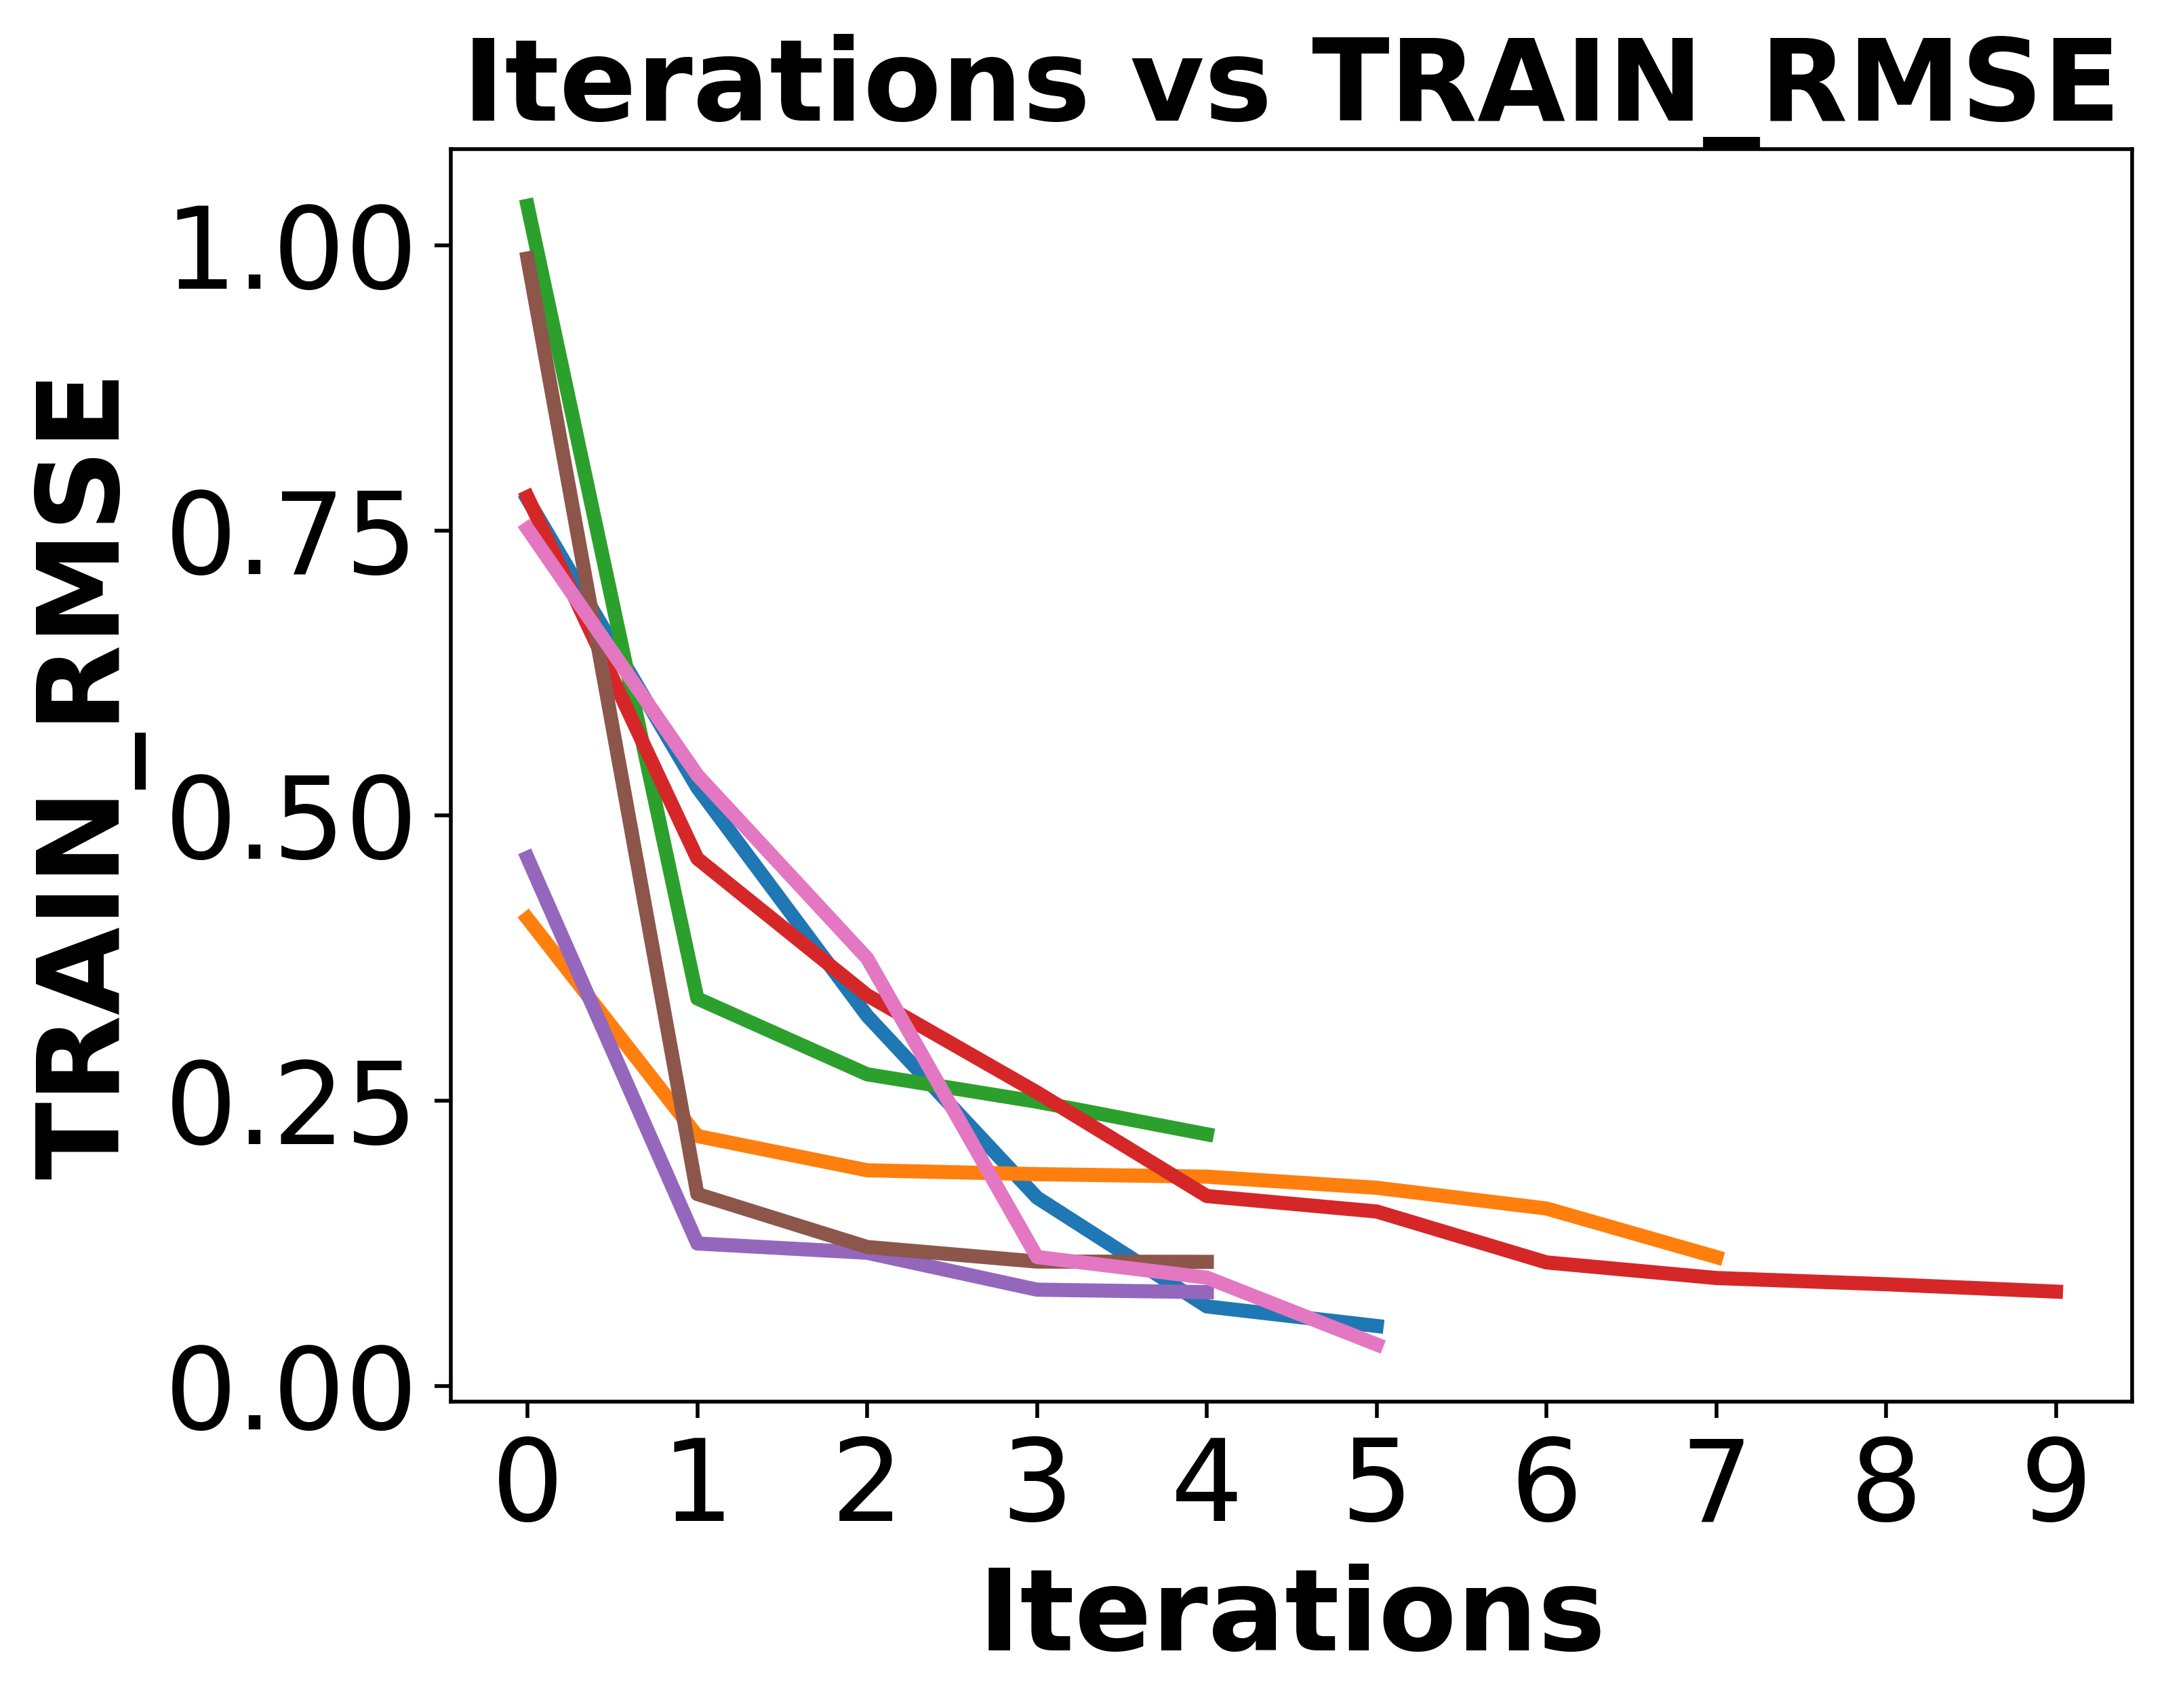

[0.8392135899871523 0.6160125453861106 0.4375195515497629
 0.3188442023755683 0.4263158405925526 0.4137484980337465 nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.5242629948717584 0.4434113410725992 0.418013738679761
 0.4107413641728187 0.4016192943793152 0.4225916115517017
 0.3875807071780825 0.4036652603373401 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[1.016434955212846 0.3757758266141596 0.28960308126071305
 0.29411144809244066 0.27951032029391204 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.6253732266193048 0.3078664972170338 0.23420361603334605
 0.22163694652662347 0.1641216634777137 0.1688164637773978
 0.1704847468515972 0.22278770750535826 0.18975585459240465
 0.19147920071306468]
[0 1 2 3 4 5 6 7 8 9]
[0.5455887058750033 0.10548192399410047 0.1094822021721542
 0.07999958447879421 0.06596394021921173 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.8739540976703779 0.1104849768070647 0.10473391928578914
 0.10701108419290598 0.11371919353533501 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[1.0678498

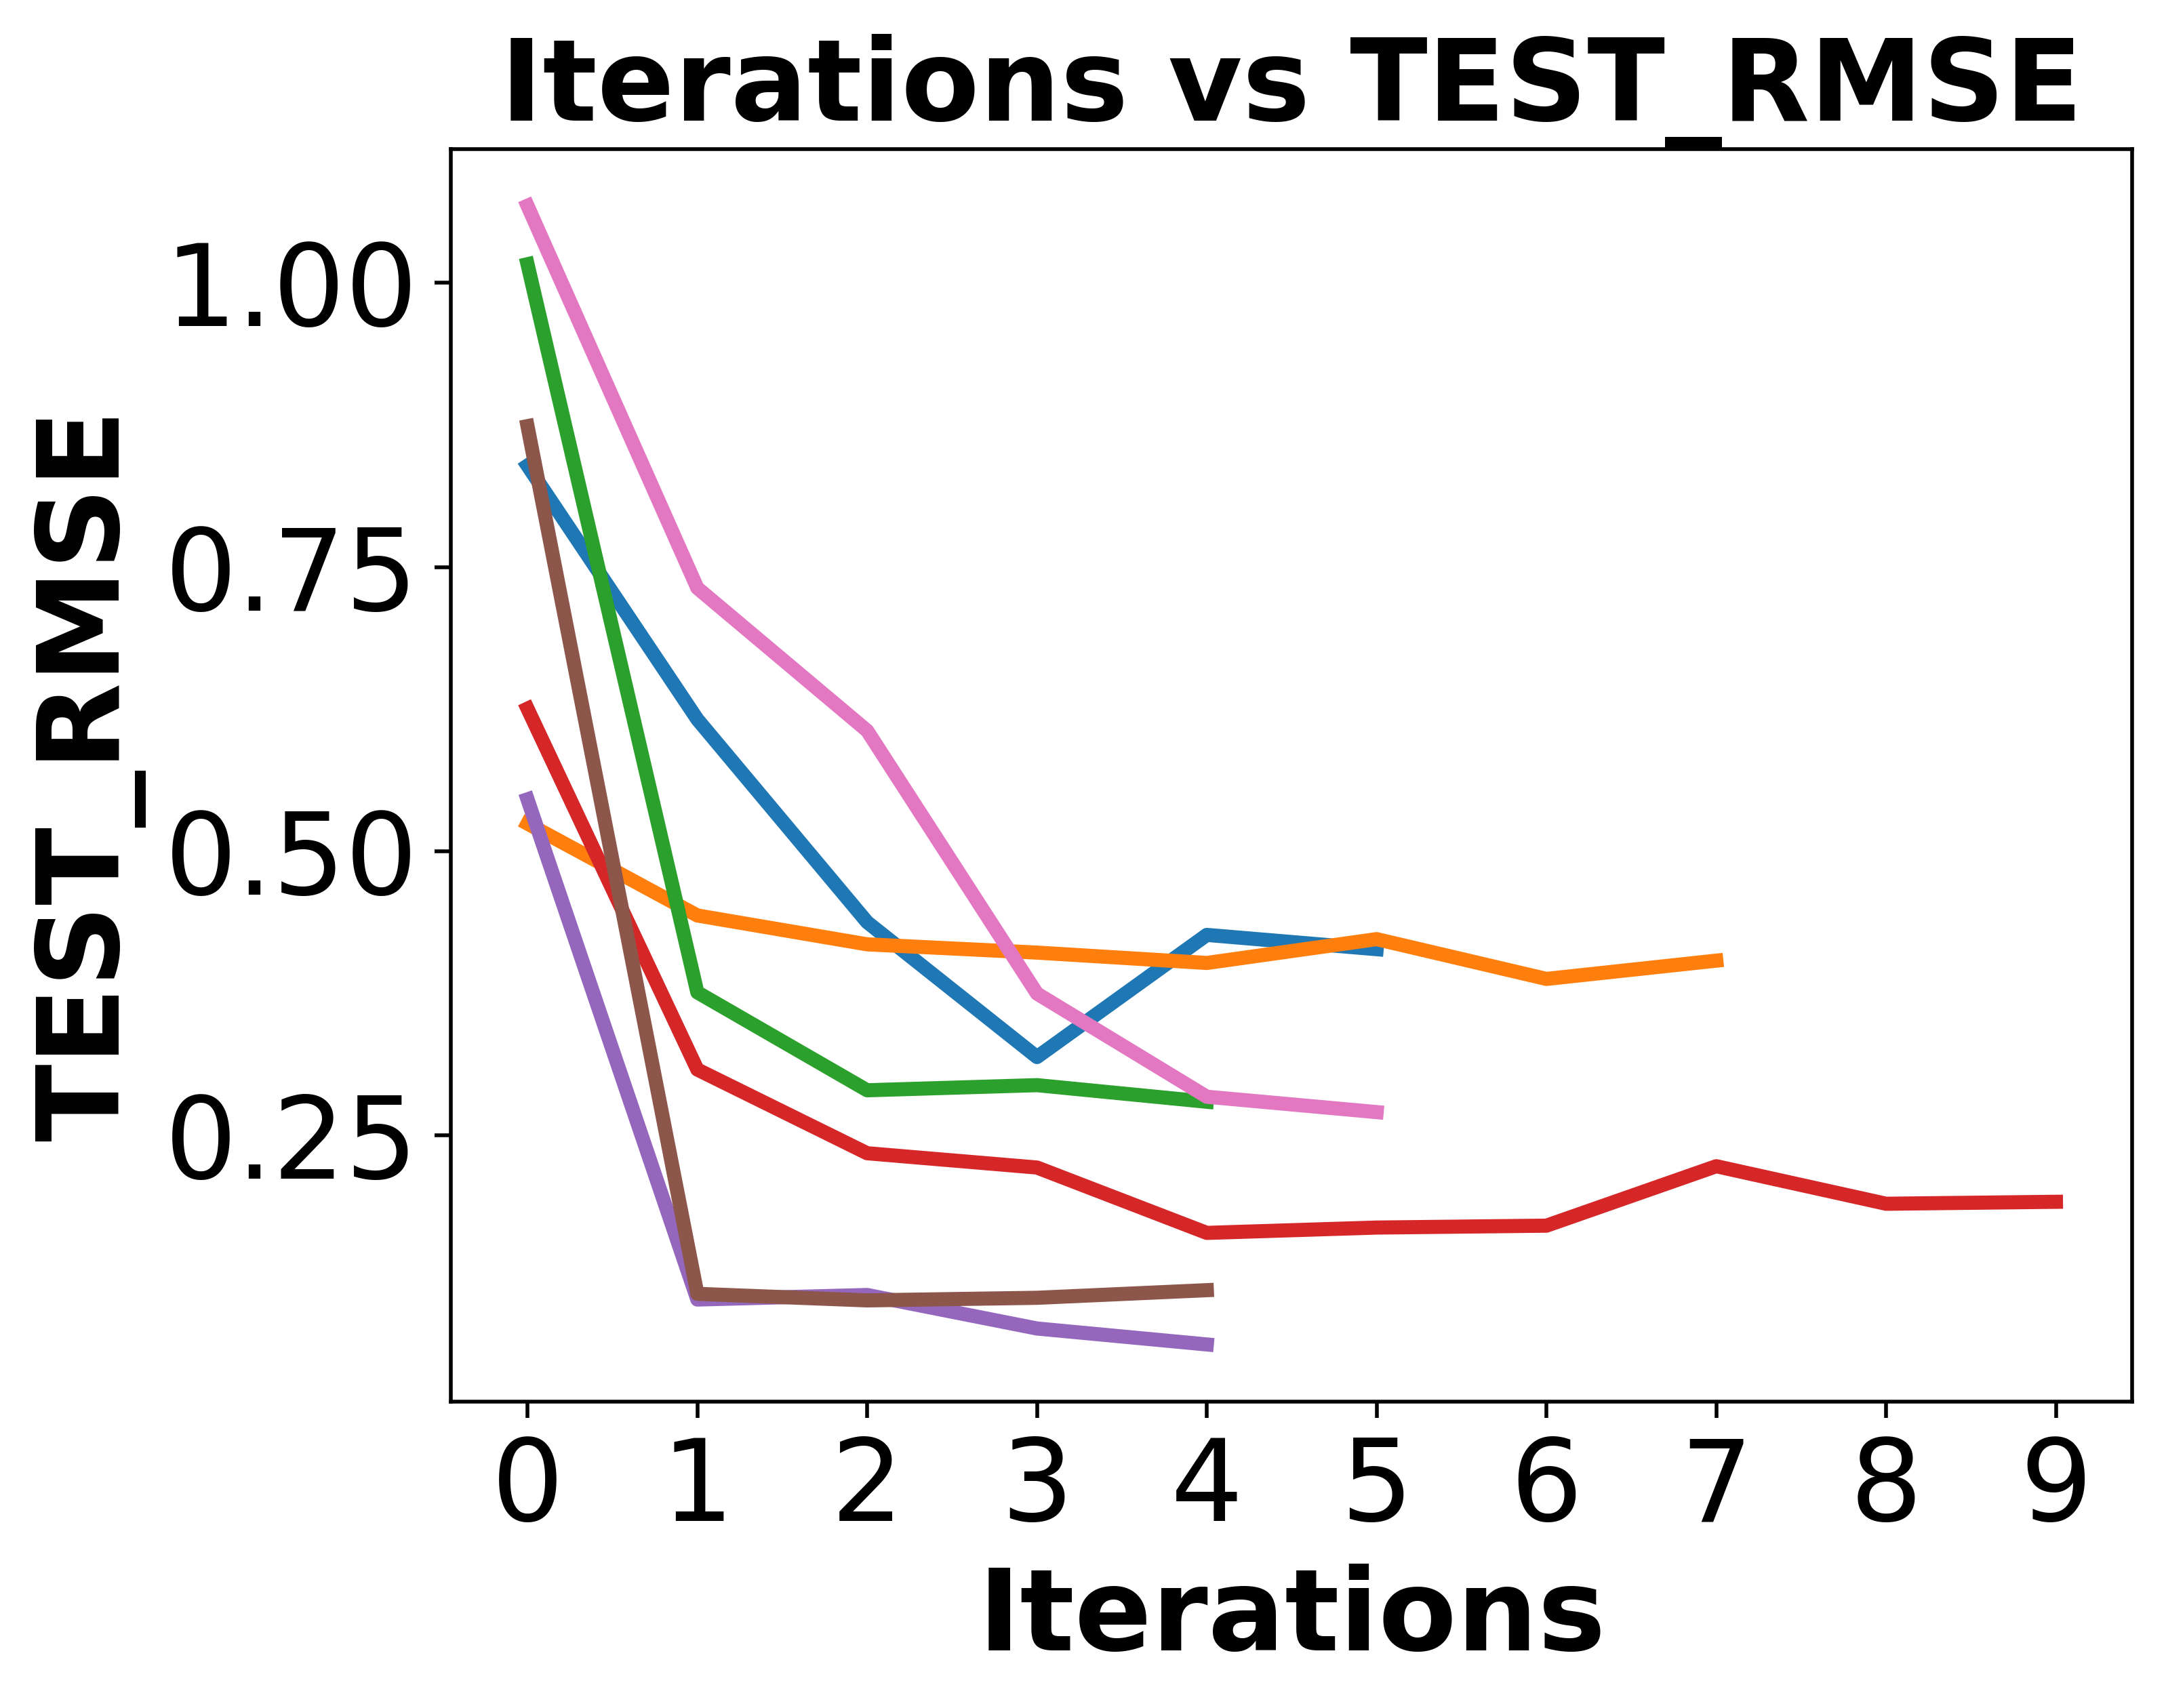

[0.4589938228408849 0.2002165370913787 0.07976812075405815
 0.04641479951336398 0.02376247226196583 0.01294516447156413 nan nan nan
 nan]
[0 1 2 3 4 5 6 7 8 9]
[0.223524698524905 0.10247128154201757 0.0840102297613529
 0.08225059442379185 0.07864220272415456 0.07522827636243143
 0.06933228468469449 0.057231933325782476 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.5426932485674166 0.08706713567059904 0.06195378693079751
 0.041955597764517294 0.0390950300072884 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.311647425624031 0.19093667281234303 0.10115198763155908
 0.06733684437140725 0.04155366689374474 0.042147652977152686
 0.03871551586579383 0.0413263897818229 0.02436898033158169
 0.028652418625473183]
[0 1 2 3 4 5 6 7 8 9]
[0.16661930144849554 0.029870689252446212 0.029497064133496956
 0.0190106682247099 0.020521842132201238 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.5409649775145002 0.02896709104022013 0.02461306800590715
 0.017475359045591277 0.022649845213962128 nan nan nan nan nan]
[0 1 2 

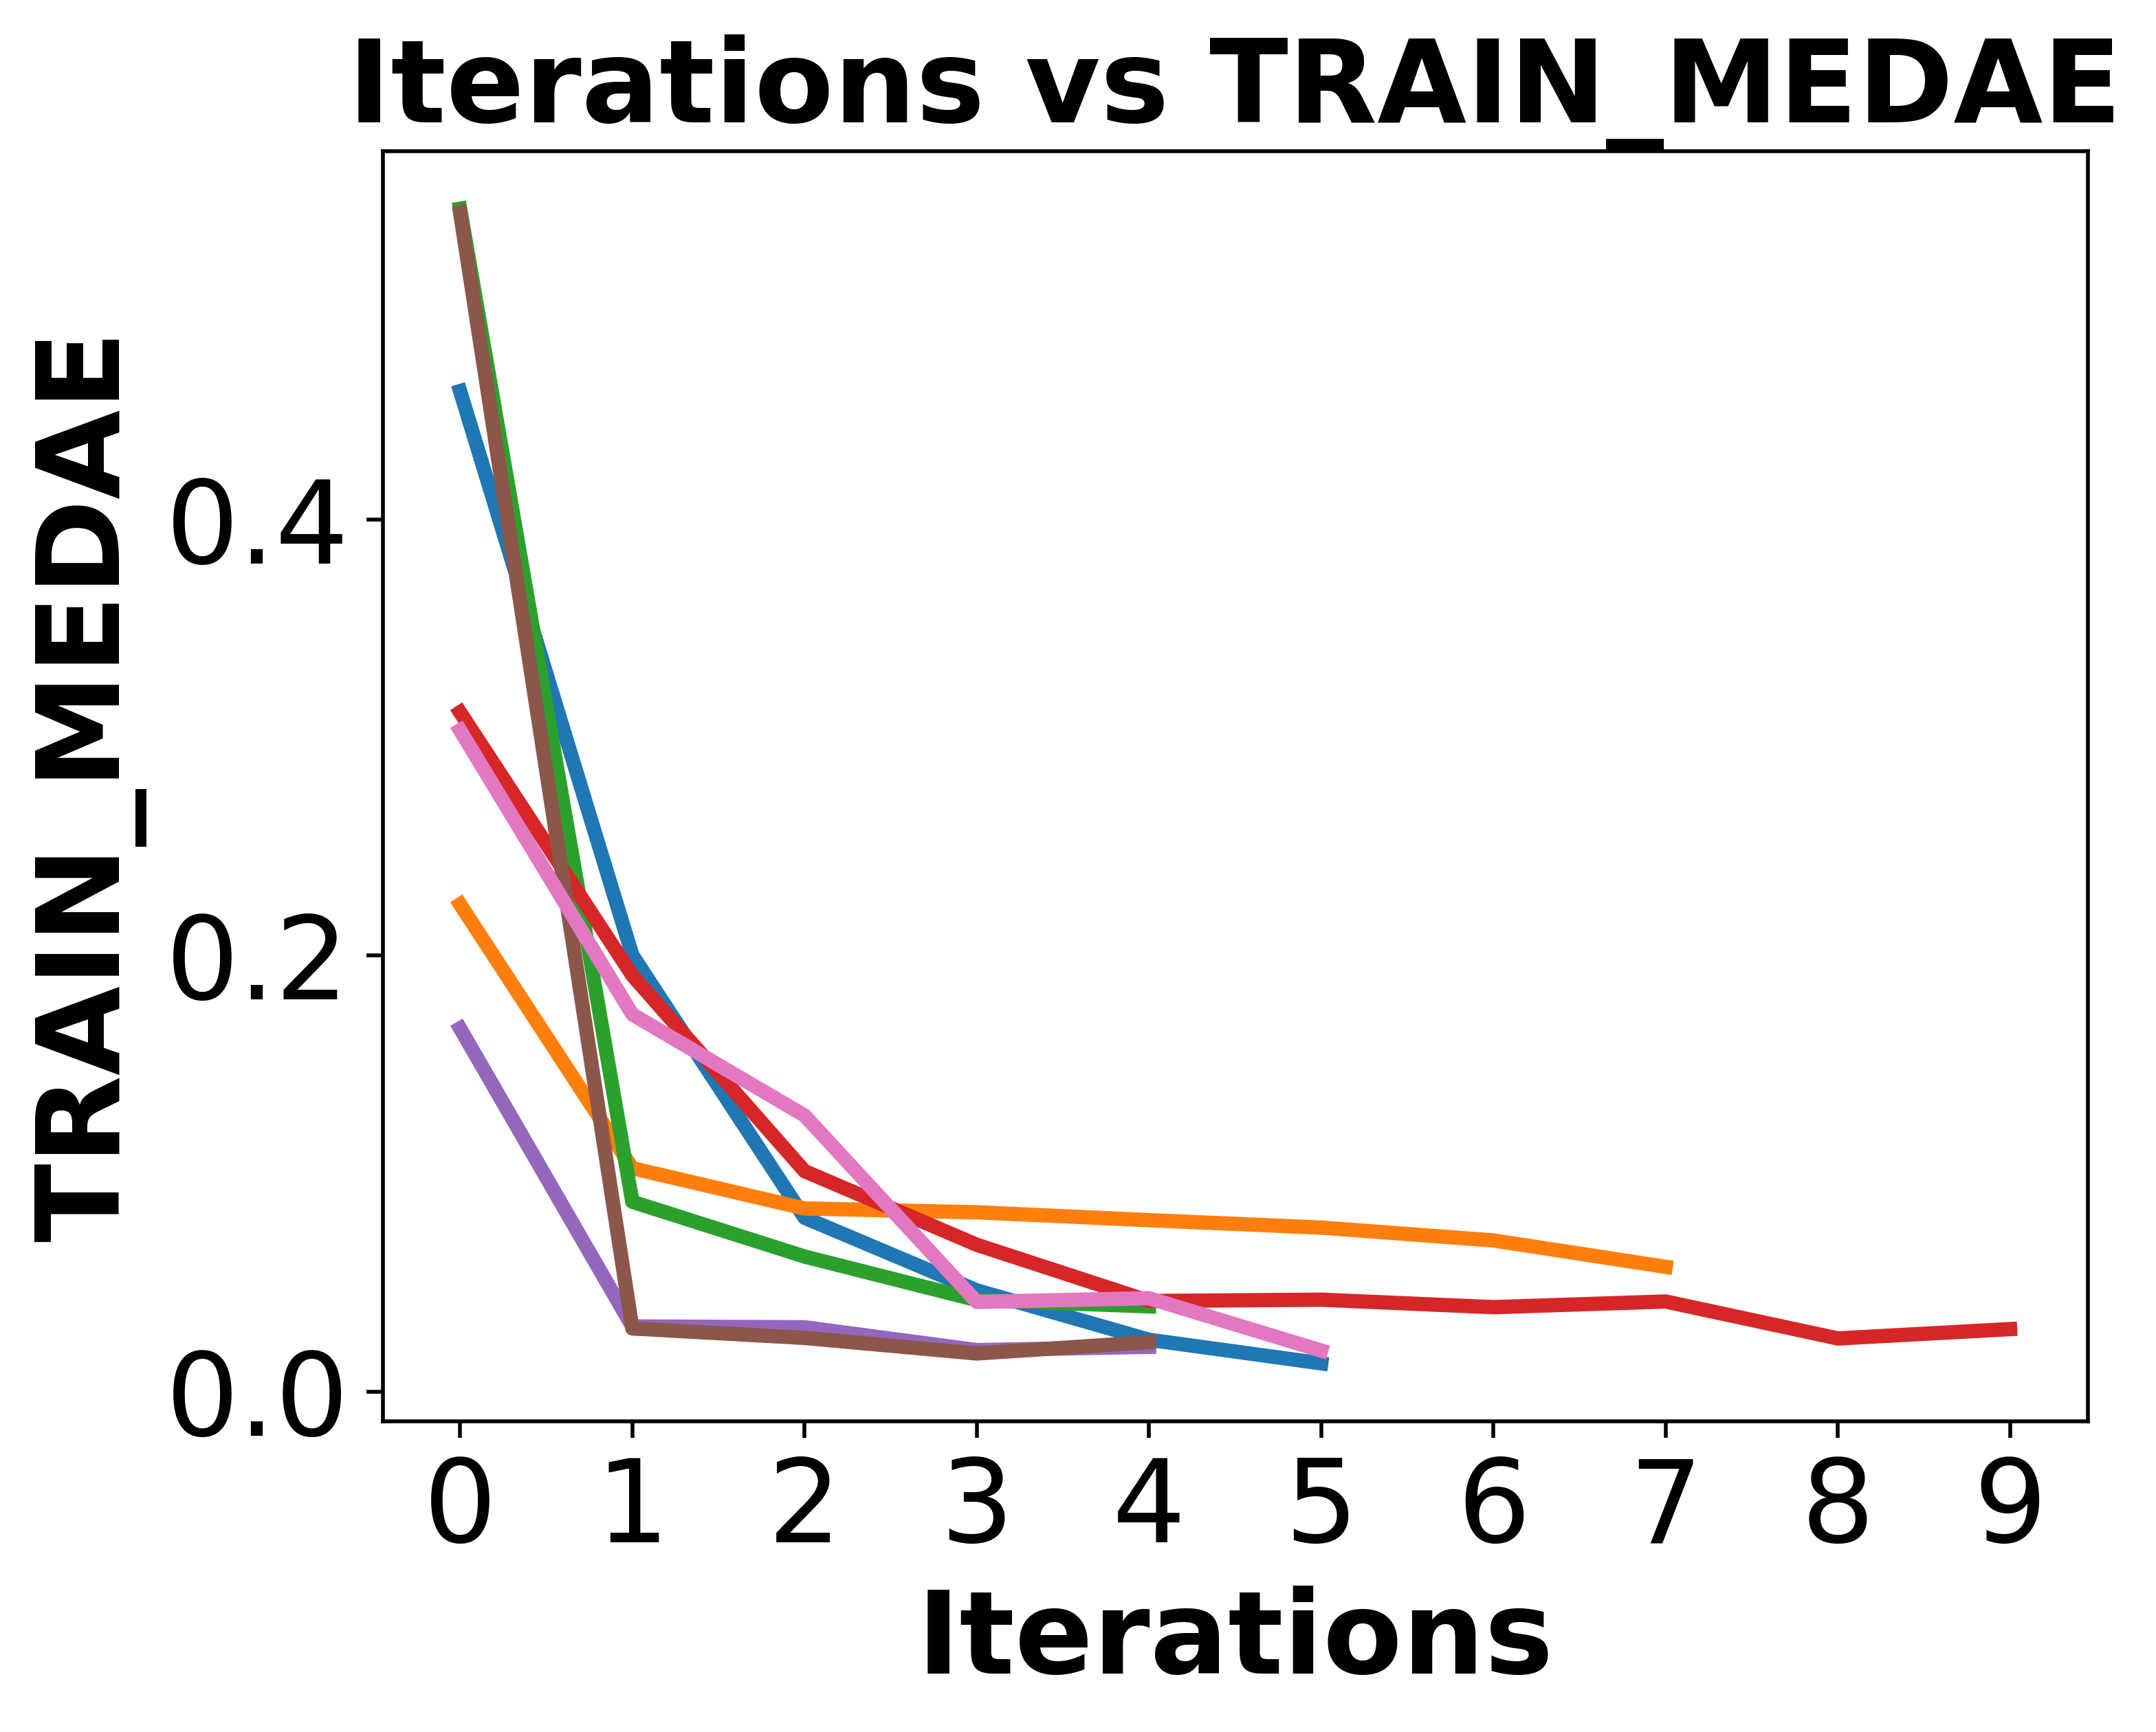

[0.4614076793818631 0.24693672639861602 0.13330107457366994
 0.036560719236919226 0.038415345369799785 0.017481523629962182 nan nan
 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.1700747203025154 0.14355575334885373 0.14941437344868885
 0.14774339687683835 0.12647934060414534 0.14757872036161993
 0.09791923167105304 0.10031586226430468 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.6622018116283606 0.11062081118488404 0.1016685070434214
 0.10419191850629794 0.10820471862318687 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.3442022093176554 0.1878124077381812 0.10341099122942926
 0.059361641690872165 0.05143523201288415 0.03739531413347248
 0.04602174281161015 0.04015352656695409 0.038764969455220184
 0.03877694165368062]
[0 1 2 3 4 5 6 7 8 9]
[0.18779516449195002 0.02242749434494673 0.02674632240315382
 0.03374745148357937 0.025435633348072417 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[0.5404985434050895 0.04236247509461887 0.03734542247828697
 0.03422672795501358 0.033400340129794766 nan nan nan nan nan]
[0 1

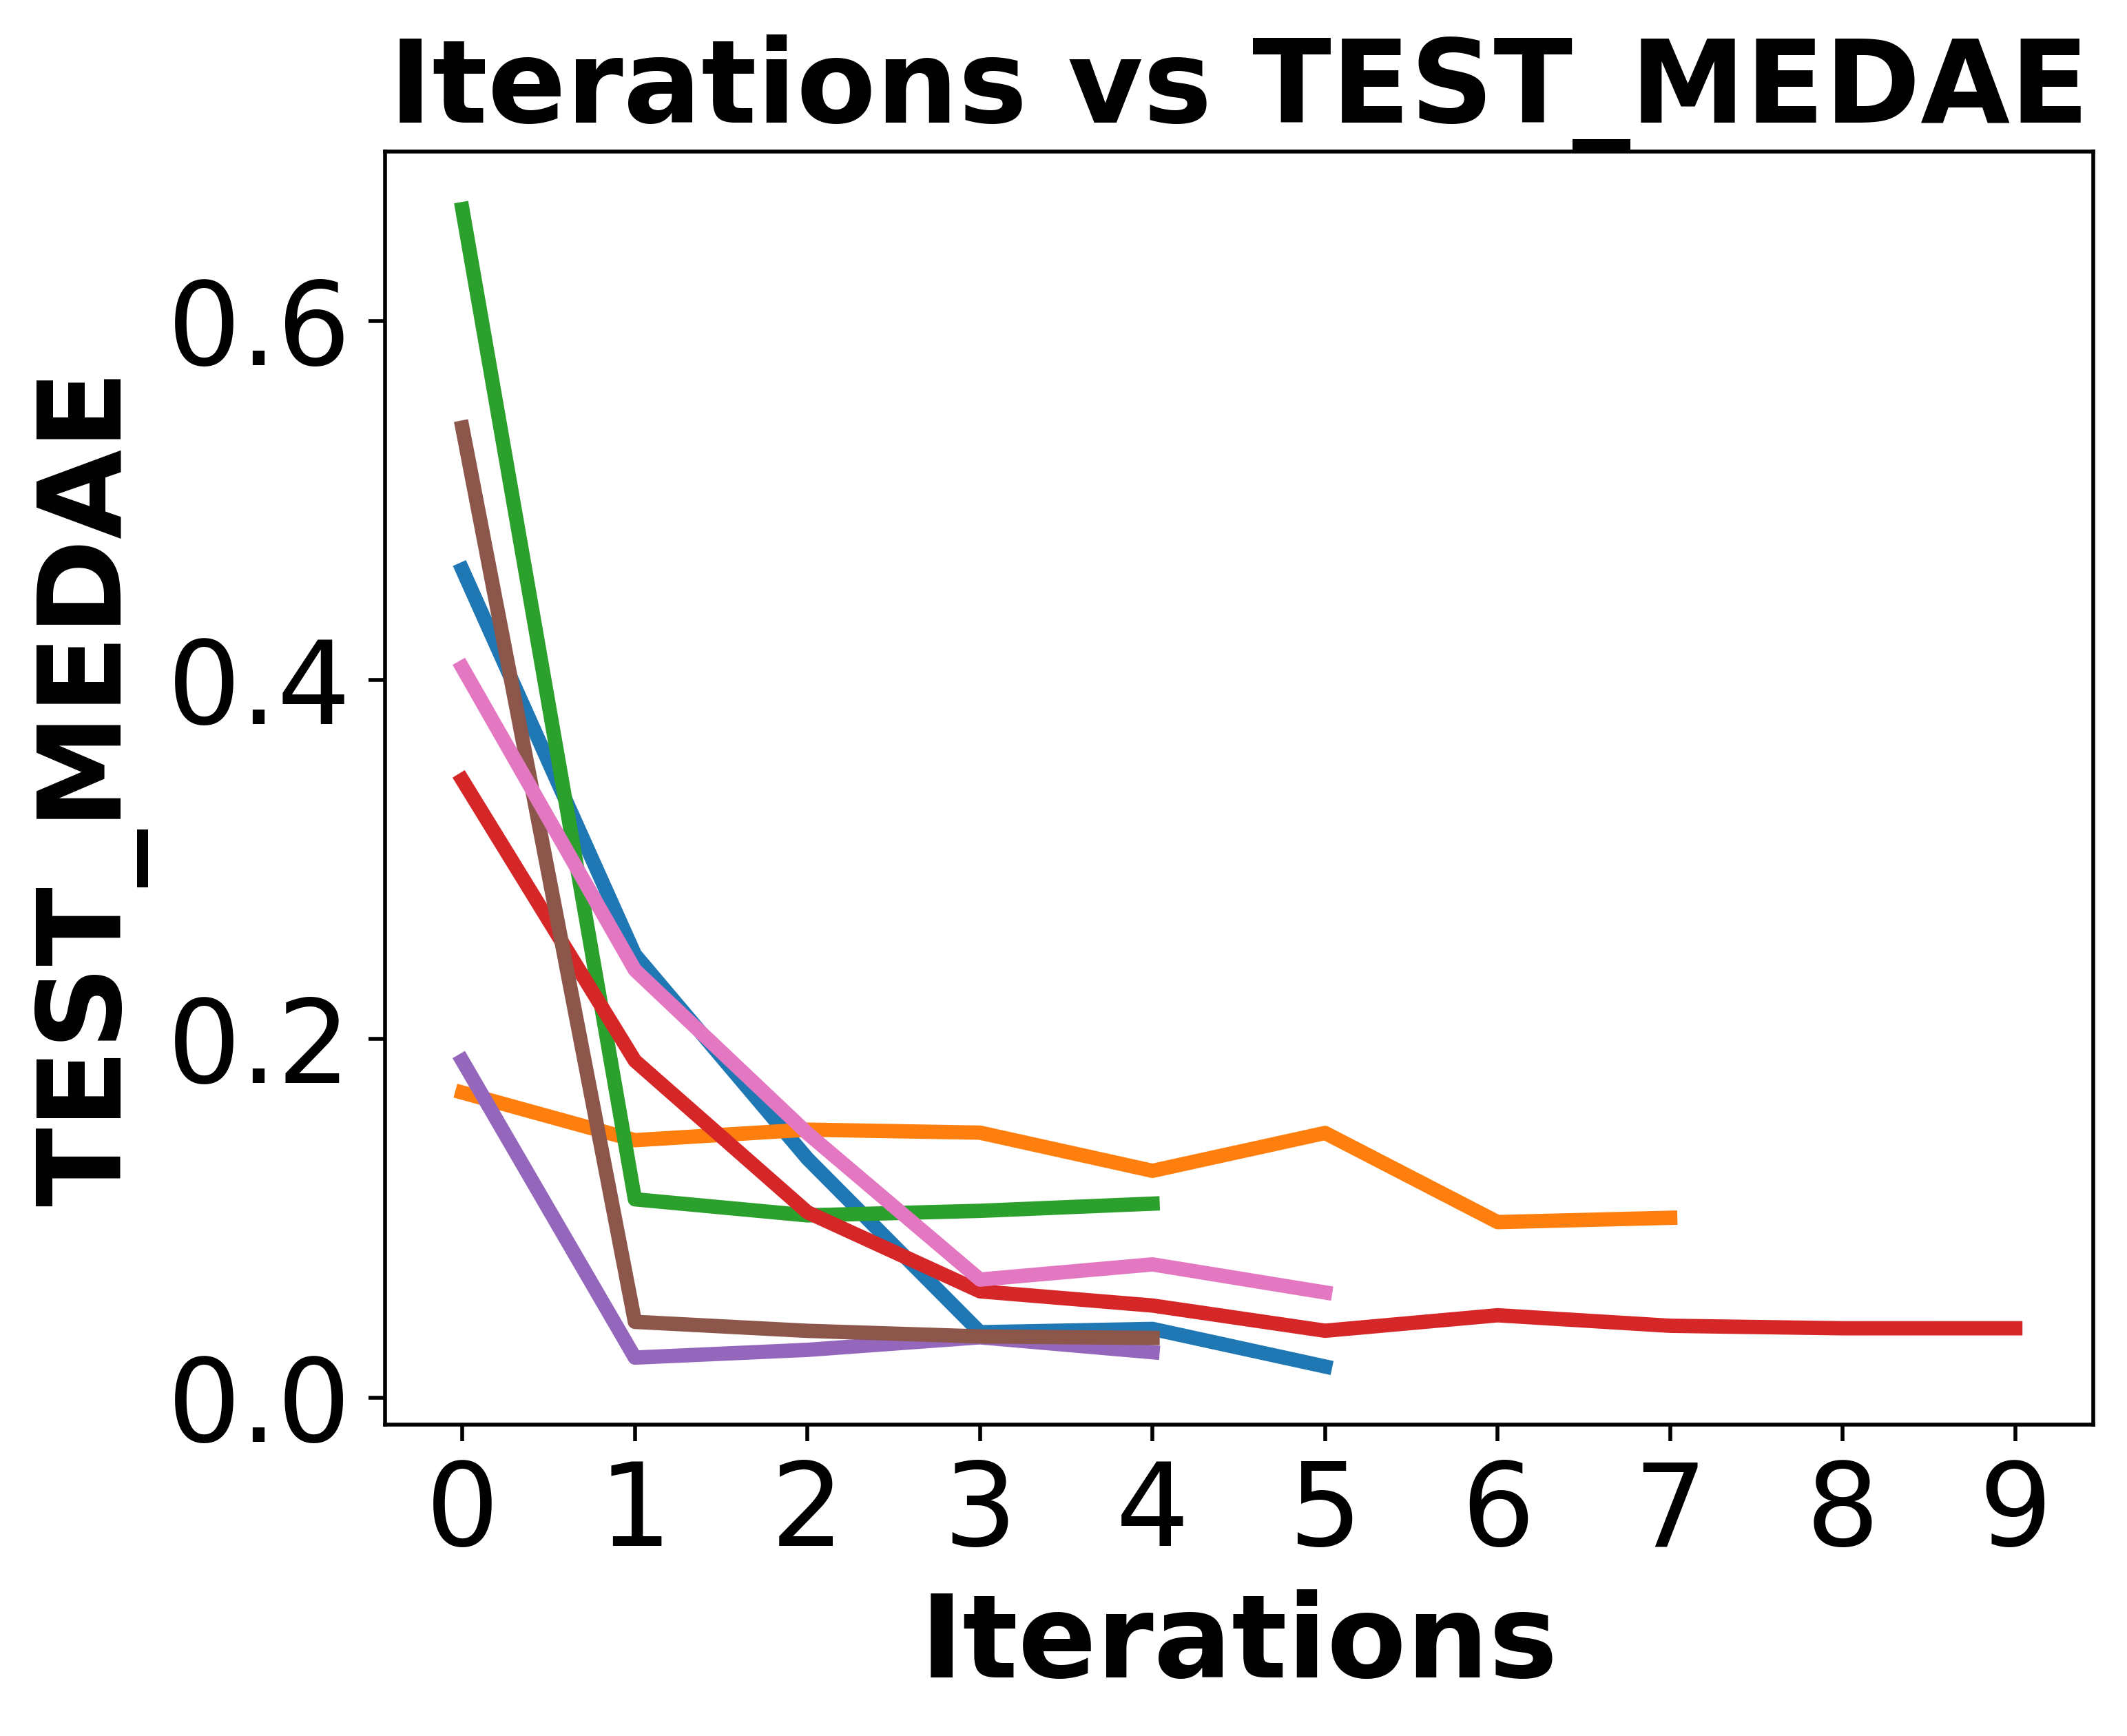

[50.02174032198835 26.784206682251106 11.97748795009282 5.407565283382296
 2.634230102435154 1.6877570941138105 nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[16.092217493309814 6.352003721398262 5.6939974387990695 5.974531452133415
 4.660239829213482 5.252423697923347 4.3593510809359595 3.1686938241715
 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[41.92509919695692 6.398556637452043 4.426612642373629 4.322085445341679
 3.462220728338236 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[34.869034055701306 16.087733206635264 11.551758544460982
 6.917930887414405 4.198025509932506 3.9750522999518973 3.3117226950810115
 4.139685697296759 2.1368992223822687 2.9178212579406986]
[0 1 2 3 4 5 6 7 8 9]
[17.243733987943628 4.13829042696092 4.2691542597142265 2.5714232829408243
 2.7419034511814404 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[134.5011873803058 11.560598744117934 8.604550829316729 6.658780637204381
 10.106642278809396 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[15.056277847480185 9.607573862541061 6.2198945

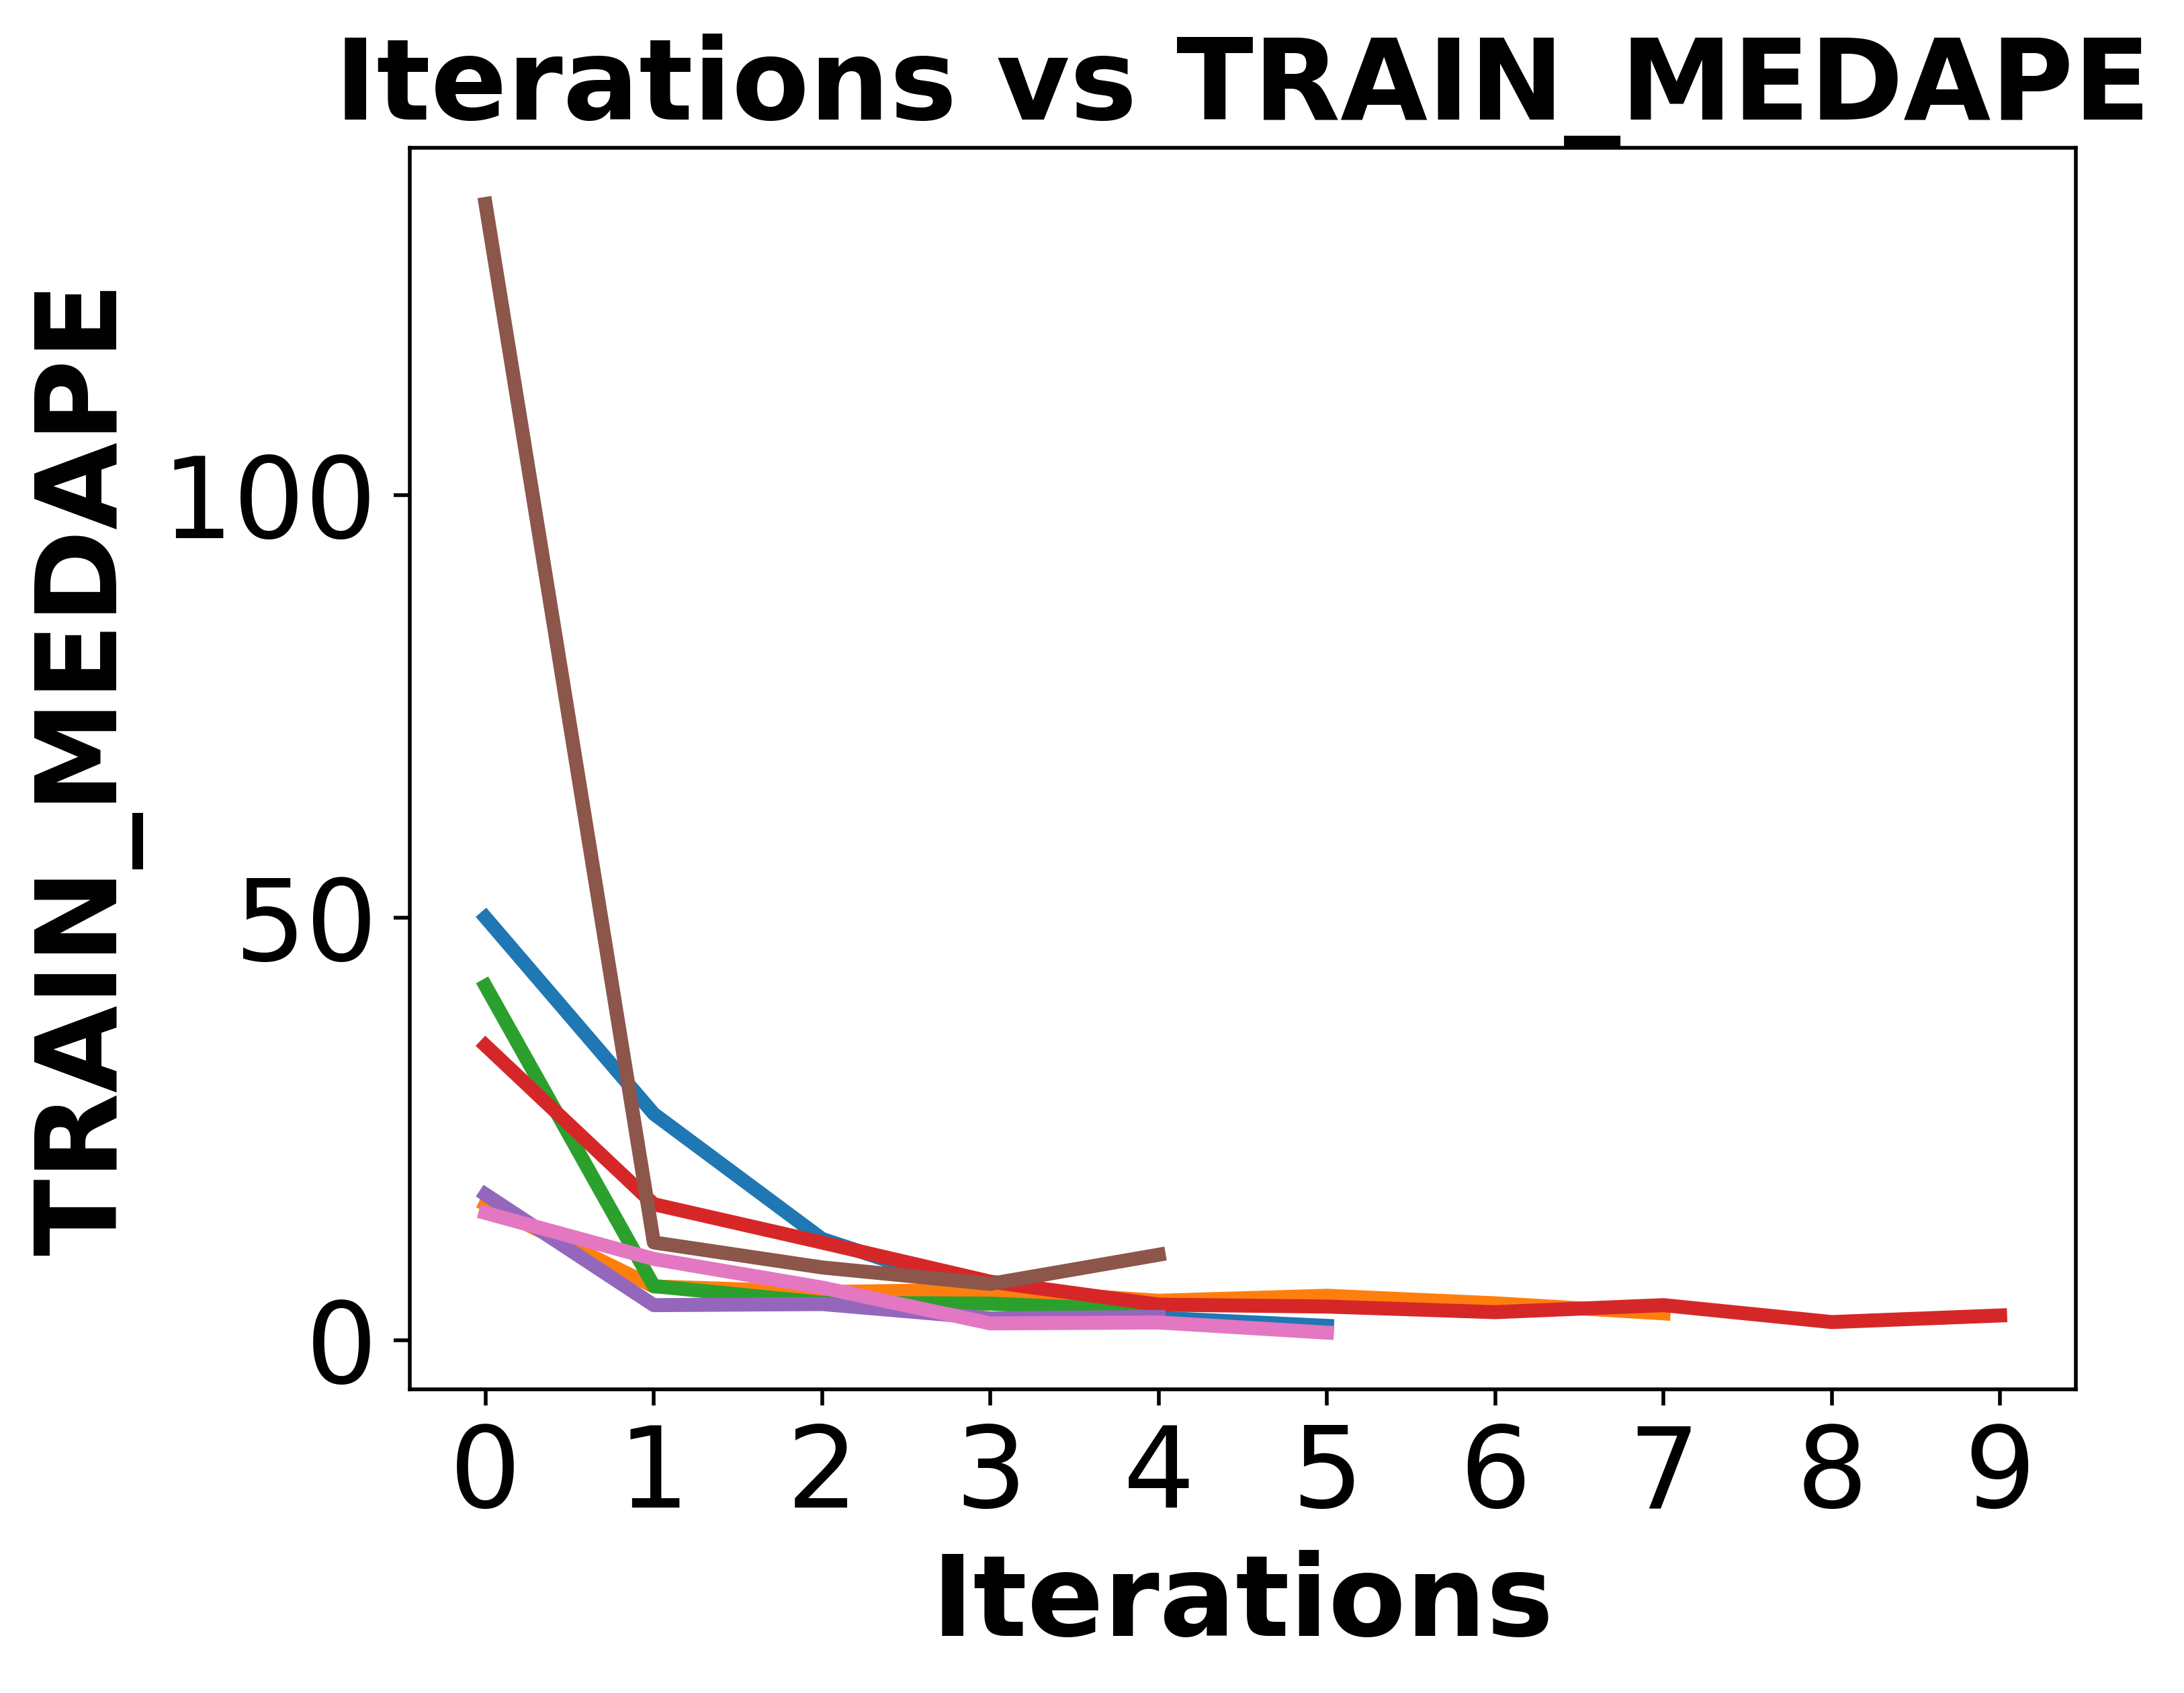

[46.1577454032991 30.401371557429037 18.77424041792389 5.770662144956647
 7.610498813135514 1.9177848911260635 nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[10.000663808540981 9.130343177448788 8.846445328322735 7.263656108055147
 6.171932468283369 5.747060205527845 5.919017006235744 4.679152138831072
 nan nan]
[0 1 2 3 4 5 6 7 8 9]
[51.70940210481874 8.012392656351668 4.735100590673358 6.673487537523067
 6.3504119441385285 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[41.562066312707074 18.364303354132375 9.253374571931193 7.820437505285254
 6.964701067841816 5.190334218591562 4.778362649533189 5.2066136705996975
 5.778304447807276 6.062139418825472]
[0 1 2 3 4 5 6 7 8 9]
[19.15093719688754 2.9887372743759024 3.6061697595012863 3.898088271965863
 3.503276755384877 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[81.15340228402263 13.115681414627948 9.039191024276947 9.756471729055633
 10.999892274331481 nan nan nan nan nan]
[0 1 2 3 4 5 6 7 8 9]
[21.461207129059343 11.564573358862624 7.72723676173

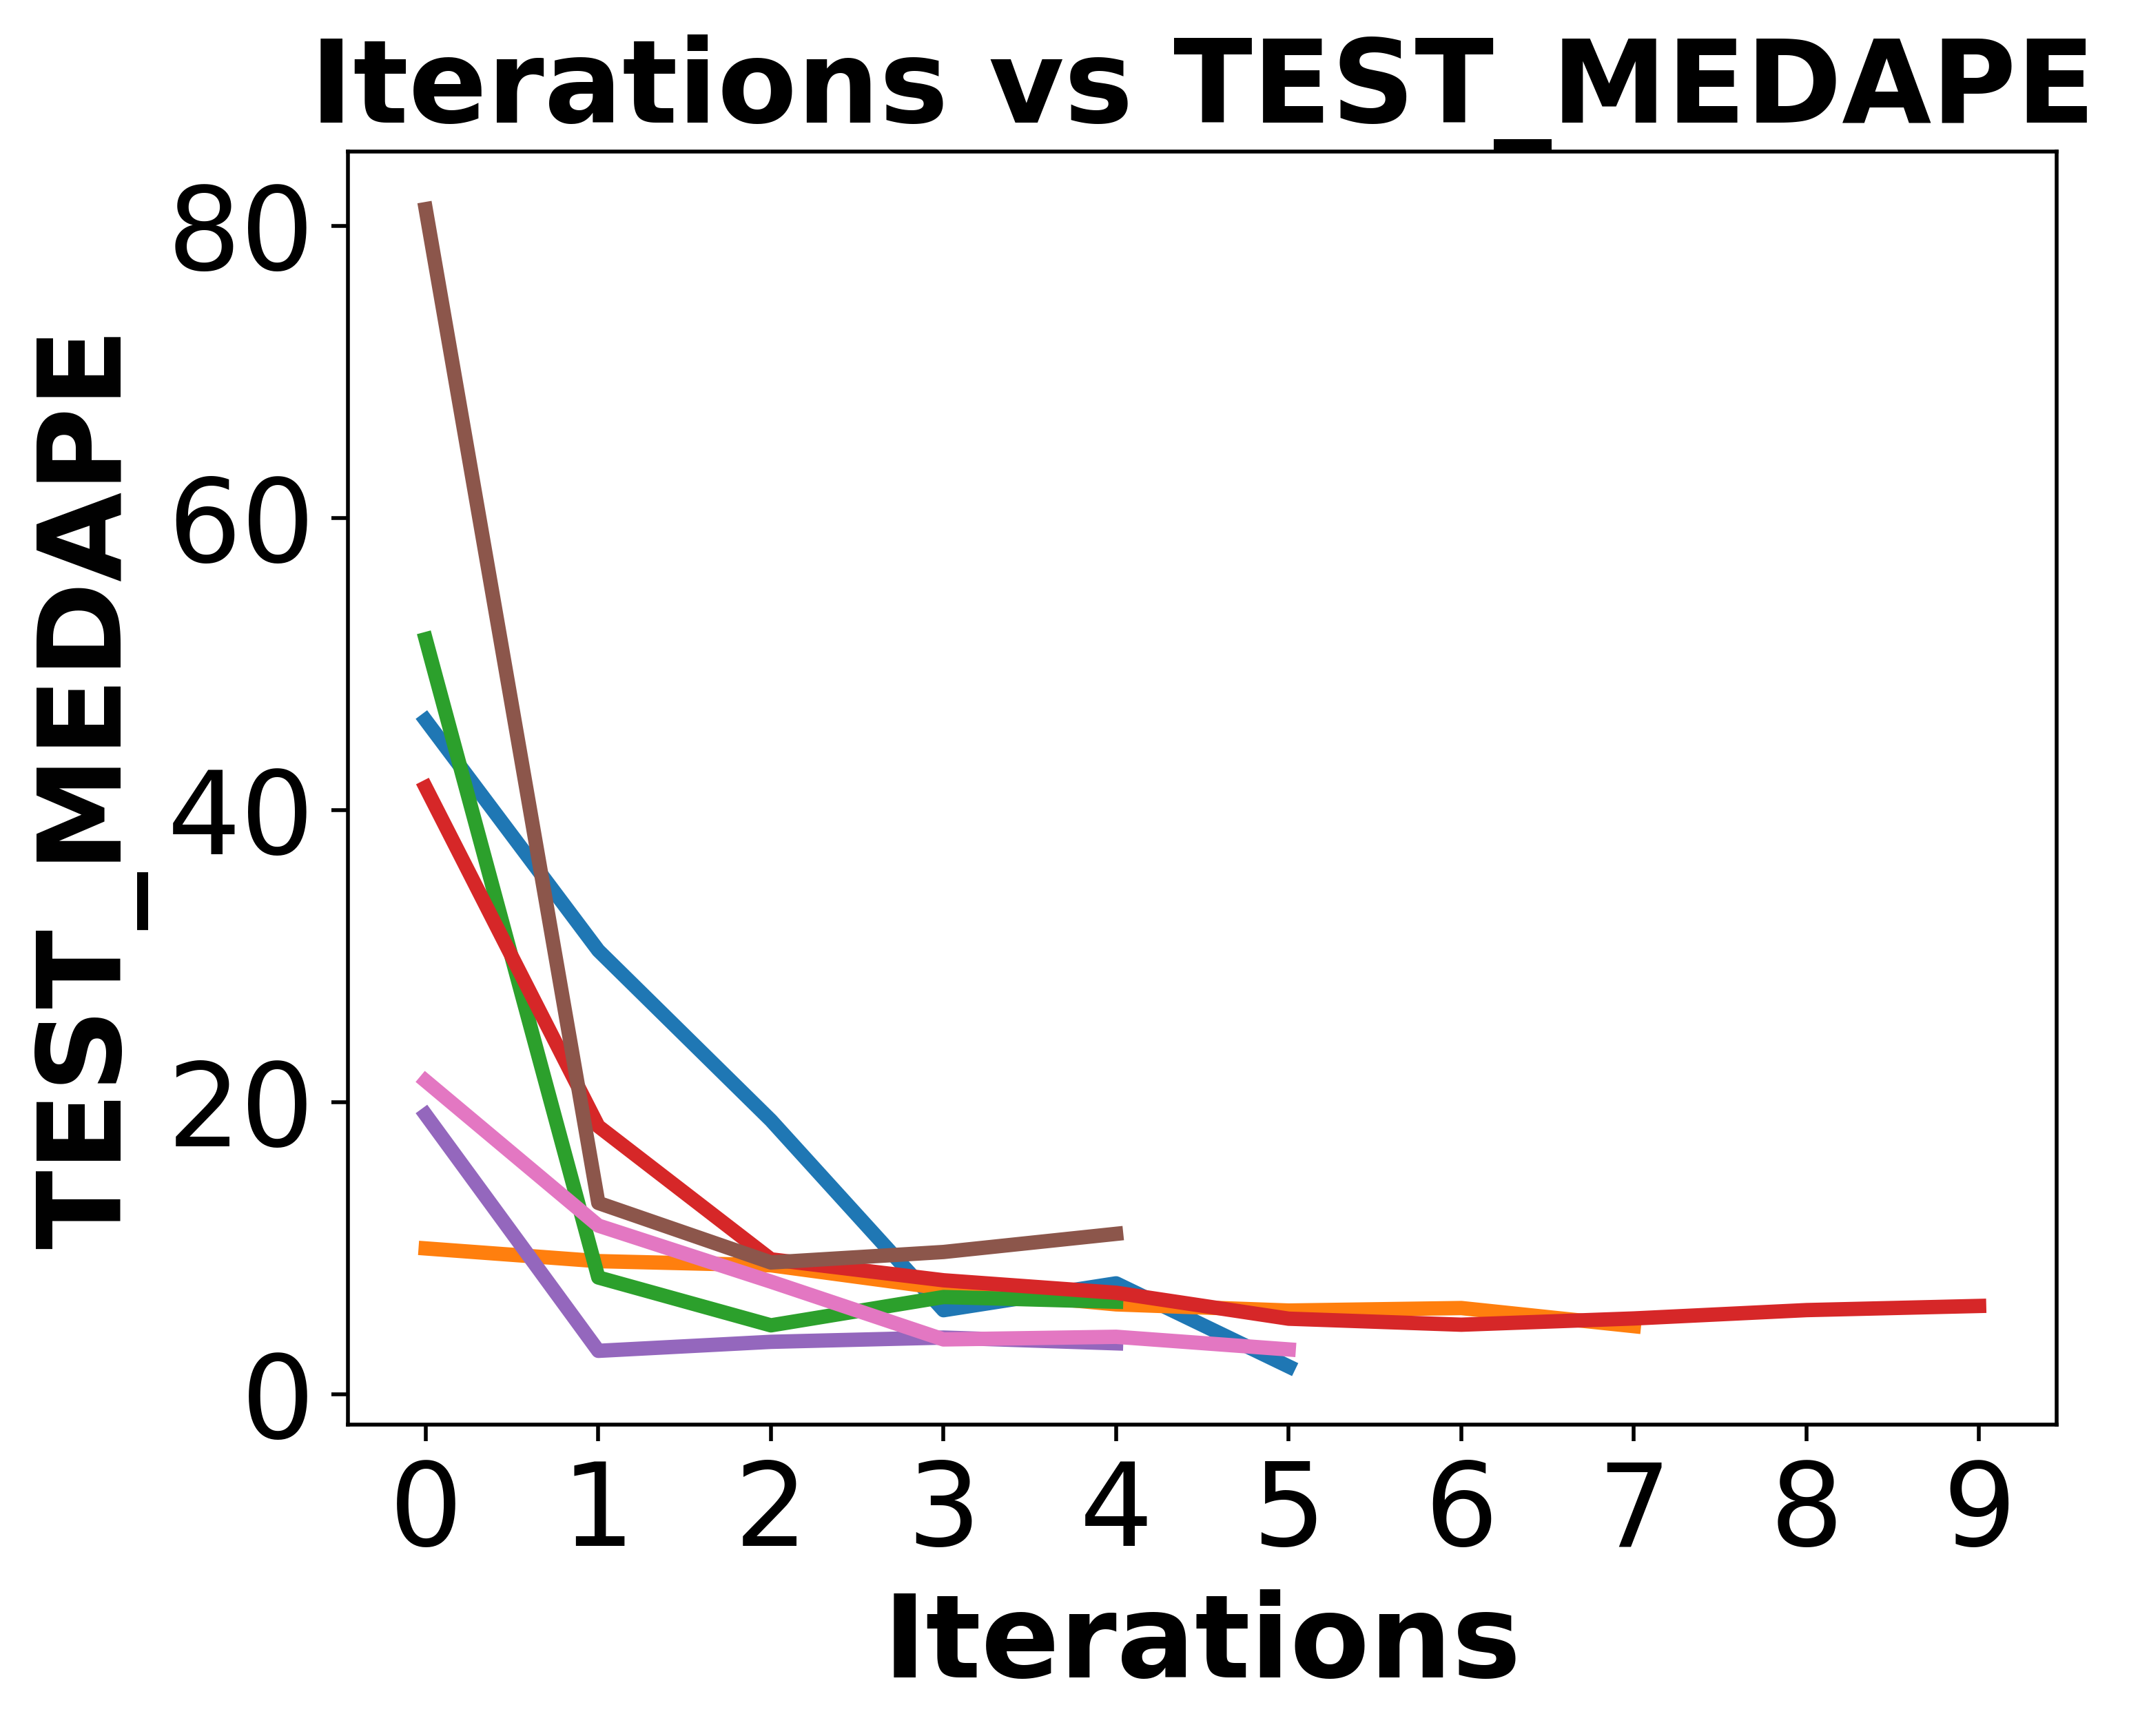

In [ ]:
#Plotting

#benchmark_list = ["NPB", "NPB", "SPEC2006", "SPEC2006"]
#algo_list = ["npb_ep", "npb_mg", "leslie3d", "perlbench"]

spec_float_benchmark_list = ["SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006"]
spec_float_algo_list = ["603.bwaves_s","607.cactuBSSN_s","619.lbm_s","621.wrf_s","627.cam4_s","628.pop2_s","638.imagick_s","644.nab_s","649.fotonik3d_s","654.roms_s","416.gamess","433.milc","434.zeusmp","435.gromacs","437.leslie3d","447.dealII","450.soplex","453.povray","454.calculix"]
spec_float_algo_fname_list = ["603.bwaves_s","607.cactuBSSN_s","619.lbm_s","621.wrf_s","627.cam4_s","628.pop2_s","638.imagick_s","644.nab_s","649.fotonik3d_s","654.roms_s","416.gamess","433.milc","434.zeusmp","435.gromacs","437.leslie3d","447.dealII","450.soplex","453.povray","454.calculix"]
spec_float_benchmark_title = 'SPEC_Float'

spec_int_benchmark_list = ["SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2017","SPEC2006","SPEC2006","SPEC2006","SPEC2006","SPEC2006"]
spec_int_algo_list = ["600.perlbench_s","602.gcc_s","605.mcf_s","620.omnetpp_s","623.xalancbmk_s","625.x264_s","631.deepsjeng_s","641.leela_s","648.exchange2_s","657.xz_s","401.bzip2","456.hmmer","458.sjeng","462.libquantum","473.astar"]
spec_int_algo_fname_list = ["600.perlbench_s","602.gcc_s","605.mcf_s","620.omnetpp_s","623.xalancbmk_s","625.x264_s","631.deepsjeng_s","641.leela_s","648.exchange2_s","657.xz_s","401.bzip2","456.hmmer","458.sjeng","462.libquantum","473.astar"]
spec_int_benchmark_title = 'SPEC_Int'

npb_other_benchmark_list = ["NPB","NPB","NPB","NPB","OTHER","OTHER","OTHER"]
npb_other_algo_list = ["npb_ep","npb_mg","npb_sp","npb_sp-mz","matmul","montecarlo","quicksort"]
npb_other_algo_fname_list = ["npb_ep","npb_mg","npb_sp","npb_sp-mz","matmul","montecarlo","quicksort"]
npb_other_benchmark_title = 'NPB_OTHER'

# Assign variable with which list is to be processed
benchmark_list = npb_other_benchmark_list
algo_list = npb_other_algo_list
algo_fname_list = npb_other_algo_fname_list
benchmark_title = npb_other_benchmark_title
plot_file_ext=".eps"

set_pub()
#plot_nnmodel_vs_autokeras(benchmark_title, algo_list)

plot_iteration_metric(benchmark_title, algo_list)